In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import sparse_ops

import rbf_kernel
from densities import multivariate_normal

base_path = os.path.dirname("__file__")

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

In [3]:
data = scipy.io.loadmat('syn2d.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]
Ngrid = int(np.sqrt(xgrid.shape[0]))

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(4,8,figsize=(10,4))
plt.subplot(2,4,1)
plt.imshow(Kprior_true,aspect='auto')
plt.colorbar()
plt.subplot(2,4,2)
plt.plot(z_true)

# visualize the covariance of Z
plt.subplot(2,4,3)
plt.plot(z_init)

extent = z_true[:,0].min(), z_true[:,0].max(), z_true[:,1].min(), z_true[:,1].max()
plt.subplot(2,4,4)
plt.imshow(np.cov(x_true),aspect='auto')
plt.colorbar()

for i in range(16):
    plt.subplot(4,8,i+17)
    plt.imshow(xgrid[:,i*5+20].reshape(Ngrid,Ngrid),extent=extent,aspect='auto')
    plt.axis('off')

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

<IPython.core.display.Javascript object>

Number of data points N=500
Number of features D=200
Number of latent dimensions K=2


In [5]:
# define functions to create weight and bias variables, from TensorFlow.org
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(-0.1, shape=shape)
    return tf.Variable(initial)

def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

# z = tf.Variable(z_true, dtype=tf.float32)
z = tf.Variable(z_init*1e-3, dtype=tf.float32)
# z = tf.Variable(tf.ones([N, K])*1e-2, dtype=tf.float32)
x = tf.placeholder(tf.float32, shape=[N, D])
tg = const(tgrid)

sig_f = tf.Variable(np.log(10), dtype=tf.float32)
l = tf.Variable(np.log(10), dtype=tf.float32)
# sig_n = tf.Variable(np.log(0.01), dtype=tf.float32)
# sig_f = const(np.log(1))
# l = const(np.log(2))
sig_n = const(np.log(1))
prior_sig_f = const(np.log(1))
prior_l = const(np.log(1))
prior_sig_n = const(np.log(0.001))

Kprior = rbf(tg,lengthscale=tf.exp(prior_l),variance=tf.exp(prior_sig_f))+tf.exp(prior_sig_n)*tf.eye(N)
Kz = rbf(z,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)

loss = - multivariate_normal(x, 0, tf.cholesky(Kz)) - multivariate_normal(z, 0, tf.cholesky(Kprior))
opt = tf.train.RMSPropOptimizer(learning_rate=0.005, decay=0.95, momentum=0.1).minimize(loss)

# train network
epochs = 2000
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fd = {x:x_true}
for epoch in range(epochs) :
    opt.run(feed_dict=fd)
    current_loss,sig_f_est,sig_n_est,l_est = sess.run([loss,sig_f,sig_n,l],feed_dict=fd) 
    if epoch % 100 == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(current_loss)
             , "sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
             , "l_est=", "{:.9f}".format(np.exp(l_est)))


Epoch: 0001 loss= 99790.687500000 sig_f_est= 9.779100418 sig_n_est= 1.000000000 l_est= 9.811912537
Epoch: 0101 loss= 95051.156250000 sig_f_est= 15.186505318 sig_n_est= 1.000000000 l_est= 5.702315331
Epoch: 0201 loss= 94961.445312500 sig_f_est= 10.791866302 sig_n_est= 1.000000000 l_est= 3.923856974
Epoch: 0301 loss= 93525.742187500 sig_f_est= 12.002956390 sig_n_est= 1.000000000 l_est= 2.157600164
Epoch: 0401 loss= 93344.656250000 sig_f_est= 6.507576466 sig_n_est= 1.000000000 l_est= 1.451792240
Epoch: 0501 loss= 93207.695312500 sig_f_est= 3.675036430 sig_n_est= 1.000000000 l_est= 0.968086839
Epoch: 0601 loss= 93037.859375000 sig_f_est= 2.102269888 sig_n_est= 1.000000000 l_est= 0.645750523
Epoch: 0701 loss= 92874.703125000 sig_f_est= 1.215324521 sig_n_est= 1.000000000 l_est= 0.434303015
Epoch: 0801 loss= 92774.562500000 sig_f_est= 0.730764985 sig_n_est= 1.000000000 l_est= 0.272632331
Epoch: 0901 loss= 92730.460937500 sig_f_est= 0.509574473 sig_n_est= 1.000000000 l_est= 0.182893291
Epoch: 

In [6]:
z_est, sig_f_est, sig_n_est, l_est = sess.run([z,sig_f,sig_n,l],feed_dict=fd)
print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
      , "l_est=", "{:.9f}".format(np.exp(l_est)))

z = tf.Variable(z_est, dtype=tf.float32)
x = tf.placeholder(tf.float32, shape=[N, D])
tg = const(tgrid)

sig_n = const(np.log(0.5))
sig_f = const(sig_f_est)
l = const(l_est)
# sig_n = tf.Variable(np.log(0.1), dtype=tf.float32)
# sig_f = tf.Variable(np.log(1), dtype=tf.float32)
# l = tf.Variable(np.log(10), dtype=tf.float32)

Kprior = rbf(tg,lengthscale=tf.exp(prior_l),variance=tf.exp(prior_sig_f))+tf.exp(prior_sig_n)*tf.eye(N)
Kz = rbf(z,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)

loss = - multivariate_normal(x, 0, tf.cholesky(Kz)) - multivariate_normal(z, 0, tf.cholesky(Kprior))
opt = tf.train.RMSPropOptimizer(learning_rate=0.005, decay=0.95, momentum=0.1).minimize(loss)

# train network
epochs = 2000
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fd = {x:x_true}
for epoch in range(epochs) :
    opt.run(feed_dict=fd)
    current_loss,sig_f_est,sig_n_est,l_est = sess.run([loss,sig_f,sig_n,l],feed_dict=fd) 
    if epoch % 100 == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(current_loss)
             , "sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
             , "l_est=", "{:.9f}".format(np.exp(l_est)))


sig_f_est= 0.484575599 sig_n_est= 1.000000000 l_est= 0.113646574
Epoch: 0001 loss= 61357.304687500 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0101 loss= 59230.484375000 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0201 loss= 59230.382812500 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0301 loss= 59230.757812500 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0401 loss= 59230.285156250 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0501 loss= 59230.207031250 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0601 loss= 59230.308593750 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0701 loss= 59230.394531250 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0801 loss= 59230.164062500 sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574
Epoch: 0901 loss= 59230.488281250 sig_f_est=

sig_f_est= 0.484575599 sig_n_est= 0.500000000 l_est= 0.113646574


<IPython.core.display.Javascript object>


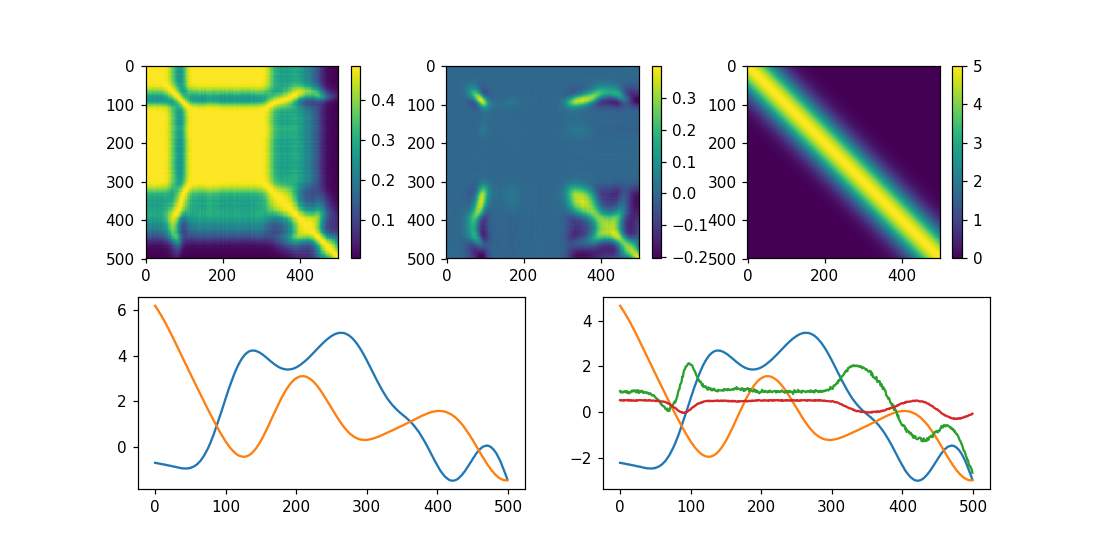

In [7]:
z_est, sig_f_est, sig_n_est, l_est = sess.run([z,sig_f,sig_n,l],feed_dict=fd)
print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
      , "l_est=", "{:.9f}".format(np.exp(l_est)))

Kz = rbf(const(z_est),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()

def align_z(x,z):
    wgt = np.linalg.lstsq(x-x.mean(), z-z.mean())[0]   
    xx = np.dot(x-x.mean(),wgt)
    return xx
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,3)
plt.plot(z_true)
plt.subplot(2,2,4)
plt.plot(align_z(z_true,z_true))
plt.plot(align_z(z_est,z_true))
